# Exploratory Data Analysis (EDA)

Goal: Answer the question, *what does money laundering look like?*

This notebook focuses on:
1. Class imbalance
2. Temporal spikes in illicit activity
3. Degree differences between licit and illicit nodes
4. Feature correlations


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Consistent palette for all visuals
PALETTE = {
    'licit': '#2a9d8f',
    'illicit': '#e76f51',
    'unknown': '#9aa0a6',
}
COLOR_LICIT = PALETTE['licit']
COLOR_ILLICIT = PALETTE['illicit']
COLOR_UNKNOWN = PALETTE['unknown']
COLOR_BASE = '#264653'
CMAP_SEQ = 'mako'
CMAP_DIV = 'vlag'
DATA_DIR = Path('../data/raw')

classes_path =  DATA_DIR / 'elliptic_txs_classes.csv'
features_path = DATA_DIR / 'elliptic_txs_features.csv'
edges_path = DATA_DIR / 'elliptic_txs_edgelist.csv'


In [2]:
classes = pd.read_csv(classes_path)
features = pd.read_csv(features_path, header=None)
edges = pd.read_csv(edges_path)

n_cols = features.shape[1]
feature_cols = ['txId', 'time_step'] + [f'feature_{i}' for i in range(n_cols - 2)]
features.columns = feature_cols

data = features.merge(classes, on='txId', how='left')

class_map = {1: 'illicit', 2: 'licit', '1': 'illicit', '2': 'licit', 'unknown': 'unknown'}
data['class_label'] = data['class'].map(class_map)

labeled = data[data['class_label'].isin(['illicit', 'licit'])].copy()
data.head()


,txId,time_step,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,class,class_label
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown,unknown
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown,unknown
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,unknown,unknown
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2,licit
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,unknown,unknown


## 1. Class Imbalance
Illicit transactions are a small fraction of labeled data. This motivates weighted losses or resampling.


/var/folders/cf/2bs7rbgn0vxf9sd837nl2tbw0000gn/T/ipykernel_52789/2190521047.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, ax=ax, palette=[COLOR_LICIT, COLOR_ILLICIT])


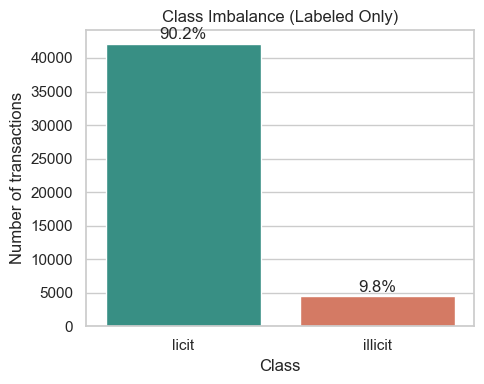

class_label
licit      90.239241
illicit     9.760759
Name: count, dtype: float64

In [3]:
counts = labeled['class_label'].value_counts().reindex(['licit', 'illicit'])
percent = counts / counts.sum() * 100

fig, ax = plt.subplots(figsize=(5, 4))
sns.barplot(x=counts.index, y=counts.values, ax=ax, palette=[COLOR_LICIT, COLOR_ILLICIT])
ax.set_title('Class Imbalance (Labeled Only)')
ax.set_xlabel('Class')
ax.set_ylabel('Number of transactions')

for i, (c, p) in enumerate(zip(counts.values, percent.values)):
    ax.text(i, c * 1.01, f'{p:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

percent


## 2. Time Step Distribution
Illicit activity is not constant. Spikes justify a temporal split rather than random train-test splits.


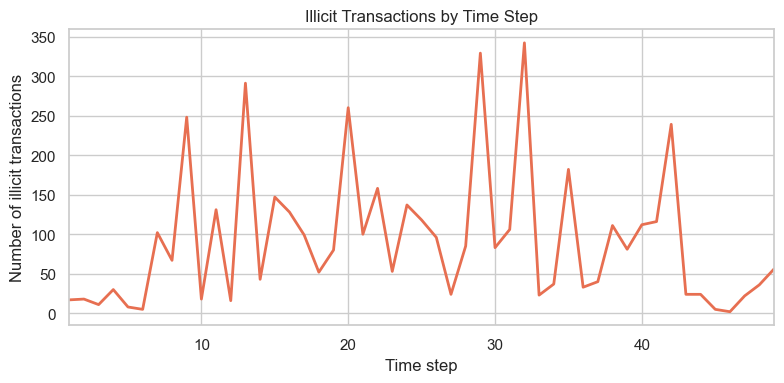

In [4]:
illicit_ts = labeled[labeled['class_label'] == 'illicit']
illicit_counts = illicit_ts.groupby('time_step').size().reindex(range(1, 50), fill_value=0)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(illicit_counts.index, illicit_counts.values, color=COLOR_ILLICIT, linewidth=2)
ax.set_title('Illicit Transactions by Time Step')
ax.set_xlabel('Time step')
ax.set_ylabel('Number of illicit transactions')
ax.set_xlim(1, 49)
plt.tight_layout()
plt.show()


## 3. Degree Analysis
Do illicit nodes connect to more nodes? We compare in-degree and out-degree across classes.


/var/folders/cf/2bs7rbgn0vxf9sd837nl2tbw0000gn/T/ipykernel_52789/3857644365.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=deg_labeled, x='class_label', y='in_degree', ax=axes[0], order=['licit', 'illicit'], palette=[COLOR_LICIT, COLOR_ILLICIT])
/var/folders/cf/2bs7rbgn0vxf9sd837nl2tbw0000gn/T/ipykernel_52789/3857644365.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=deg_labeled, x='class_label', y='out_degree', ax=axes[1], order=['licit', 'illicit'], palette=[COLOR_LICIT, COLOR_ILLICIT])


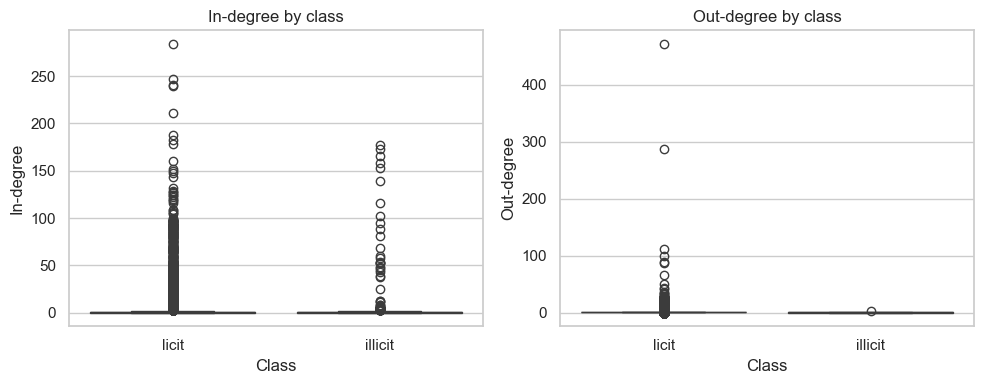

,in_degree,out_degree,total_degree
class_label,,,
illicit,1.269967,0.741694,2.011661
licit,1.909398,1.185821,3.095219


In [5]:
out_deg = edges['txId1'].value_counts()
in_deg = edges['txId2'].value_counts()

deg = pd.DataFrame({'txId': pd.Index(out_deg.index).union(in_deg.index)})
deg['out_degree'] = deg['txId'].map(out_deg).fillna(0).astype(int)
deg['in_degree'] = deg['txId'].map(in_deg).fillna(0).astype(int)
deg['total_degree'] = deg['in_degree'] + deg['out_degree']

deg_labeled = deg.merge(labeled[['txId', 'class_label']], on='txId', how='inner')

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(data=deg_labeled, x='class_label', y='in_degree', ax=axes[0], order=['licit', 'illicit'], palette=[COLOR_LICIT, COLOR_ILLICIT])
axes[0].set_title('In-degree by class')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('In-degree')

sns.boxplot(data=deg_labeled, x='class_label', y='out_degree', ax=axes[1], order=['licit', 'illicit'], palette=[COLOR_LICIT, COLOR_ILLICIT])
axes[1].set_title('Out-degree by class')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Out-degree')

plt.tight_layout()
plt.show()

deg_labeled.groupby('class_label')[['in_degree', 'out_degree', 'total_degree']].mean()


## 4. Feature Correlation Heatmap
The first 20 features show local correlations, suggesting related transaction metadata.


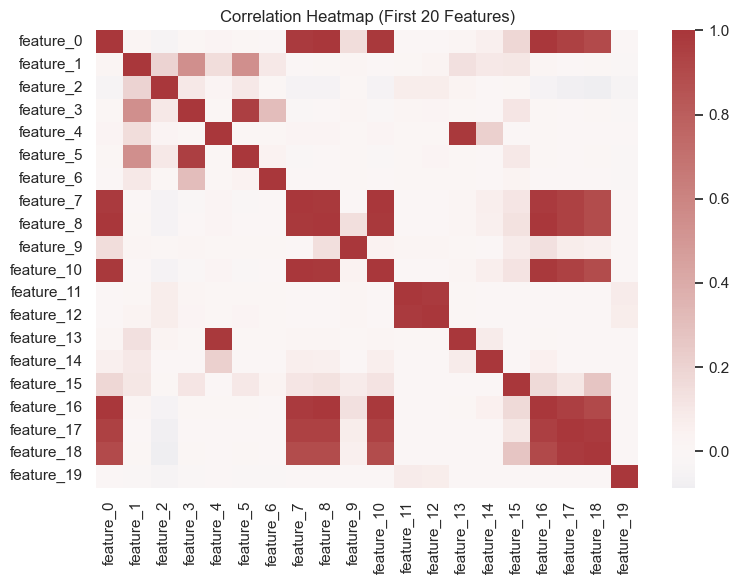

In [6]:
feature_only_cols = [c for c in data.columns if c.startswith('feature_')]
first_20 = feature_only_cols[:20]

corr = data[first_20].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, cmap=CMAP_DIV, center=0, ax=ax)
ax.set_title('Correlation Heatmap (First 20 Features)')
plt.tight_layout()
plt.show()


## 5. Graph-Specific EDA
These analyses focus on the structure of the transaction graph itself.


### 5.1 Graph size + degree distribution


Nodes: 203,769
Edges: 234,355
Directed density: 0.000006
Average in-degree: 1.150
Average out-degree: 1.150


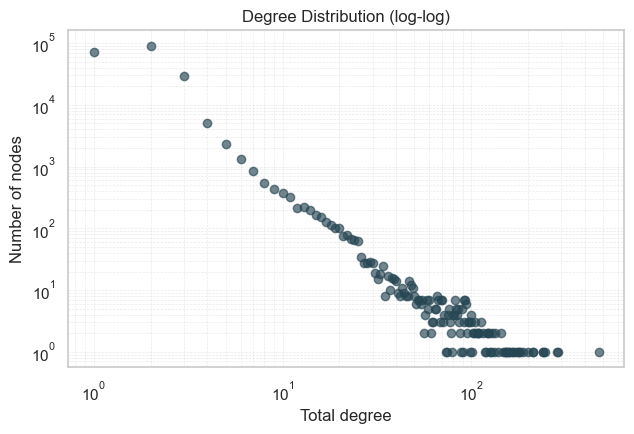

In [7]:
# Basic graph statistics
n_nodes = data['txId'].nunique()
n_edges = len(edges)
density = n_edges / (n_nodes * (n_nodes - 1))
avg_in = n_edges / n_nodes
avg_out = n_edges / n_nodes

print(f'Nodes: {n_nodes:,}')
print(f'Edges: {n_edges:,}')
print(f'Directed density: {density:.6f}')
print(f'Average in-degree: {avg_in:.3f}')
print(f'Average out-degree: {avg_out:.3f}')

out_deg = edges['txId1'].value_counts()
in_deg = edges['txId2'].value_counts()

deg = pd.DataFrame({'txId': pd.Index(out_deg.index).union(in_deg.index)})
deg['out_degree'] = deg['txId'].map(out_deg).fillna(0).astype(int)
deg['in_degree'] = deg['txId'].map(in_deg).fillna(0).astype(int)
deg['total_degree'] = deg['in_degree'] + deg['out_degree']

deg_counts = deg['total_degree'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(6.5, 4.5))
ax.loglog(deg_counts.index, deg_counts.values, marker='o', linestyle='none', alpha=0.65, color=COLOR_BASE)
ax.set_title('Degree Distribution (log-log)')
ax.set_xlabel('Total degree')
ax.set_ylabel('Number of nodes')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tight_layout()
plt.show()


### 5.2 Connected components (weakly connected)


Weakly connected components: 49
Largest component share: 3.87%


/var/folders/cf/2bs7rbgn0vxf9sd837nl2tbw0000gn/T/ipykernel_52789/2669974763.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


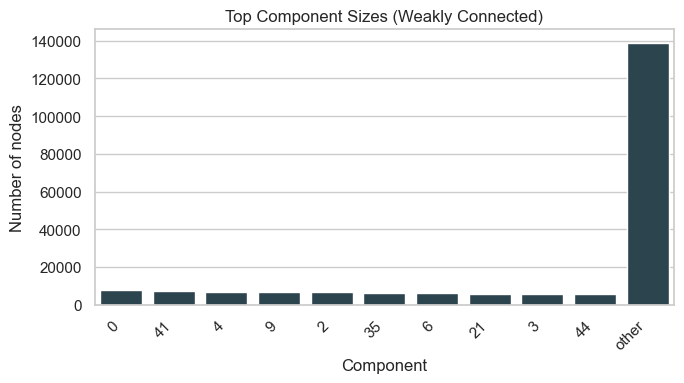

In [8]:
import scipy.sparse as sp
from scipy.sparse.csgraph import connected_components

node_ids = data['txId'].unique()
node_index = pd.Series(index=node_ids, data=np.arange(len(node_ids)))

src = node_index.loc[edges['txId1']].values
dst = node_index.loc[edges['txId2']].values

adj = sp.coo_matrix((np.ones(len(edges), dtype=np.int8), (src, dst)), shape=(n_nodes, n_nodes))
undirected = adj + adj.T

n_components, labels = connected_components(undirected, directed=False, connection='weak')
comp_sizes = pd.Series(labels).value_counts().sort_values(ascending=False)

largest_share = comp_sizes.iloc[0] / n_nodes
print(f'Weakly connected components: {n_components:,}')
print(f'Largest component share: {largest_share:.2%}')

top_k = 10
top_sizes = comp_sizes.head(top_k)
other = comp_sizes.iloc[top_k:].sum()
plot_sizes = pd.concat([top_sizes, pd.Series({'other': other})])

fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(x=plot_sizes.index.astype(str), y=plot_sizes.values, ax=ax, color=COLOR_BASE)
ax.set_title('Top Component Sizes (Weakly Connected)')
ax.set_xlabel('Component')
ax.set_ylabel('Number of nodes')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 5.3 Label mixing on edges (homophily)


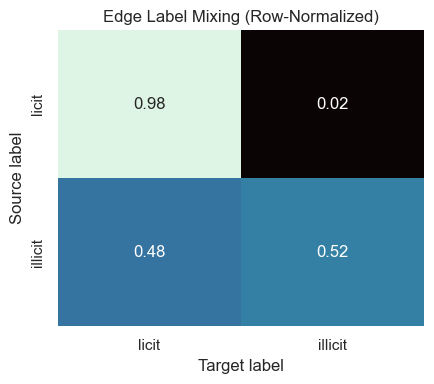

In [9]:
edge_labels = edges.merge(data[['txId', 'class_label']], left_on='txId1', right_on='txId', how='left')
edge_labels = edge_labels.rename(columns={'class_label': 'src_label'}).drop(columns=['txId'])
edge_labels = edge_labels.merge(data[['txId', 'class_label']], left_on='txId2', right_on='txId', how='left')
edge_labels = edge_labels.rename(columns={'class_label': 'dst_label'}).drop(columns=['txId'])

mask = edge_labels['src_label'].isin(['licit', 'illicit']) & edge_labels['dst_label'].isin(['licit', 'illicit'])
label_order = ['licit', 'illicit']
mix = pd.crosstab(edge_labels.loc[mask, 'src_label'], edge_labels.loc[mask, 'dst_label'], normalize='index')
mix = mix.reindex(index=label_order, columns=label_order)

fig, ax = plt.subplots(figsize=(4.5, 4))
sns.heatmap(mix, annot=True, fmt='.2f', cmap=CMAP_SEQ, cbar=False, ax=ax)
ax.set_title('Edge Label Mixing (Row-Normalized)')
ax.set_xlabel('Target label')
ax.set_ylabel('Source label')
plt.tight_layout()
plt.show()


### 5.4 Edge composition by source class


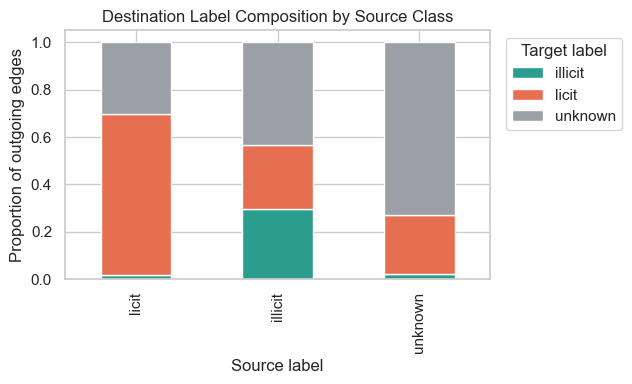

In [10]:
edge_all = edges.merge(data[['txId', 'class_label']], left_on='txId1', right_on='txId', how='left')
edge_all = edge_all.rename(columns={'class_label': 'src_label'}).drop(columns=['txId'])
edge_all = edge_all.merge(data[['txId', 'class_label']], left_on='txId2', right_on='txId', how='left')
edge_all = edge_all.rename(columns={'class_label': 'dst_label'}).drop(columns=['txId'])

comp = pd.crosstab(edge_all['src_label'], edge_all['dst_label'], normalize='index')
comp = comp.reindex(['licit', 'illicit', 'unknown'])

fig, ax = plt.subplots(figsize=(6.5, 4))
comp.plot(kind='bar', stacked=True, ax=ax, color=[COLOR_LICIT, COLOR_ILLICIT, COLOR_UNKNOWN])
ax.set_title('Destination Label Composition by Source Class')
ax.set_xlabel('Source label')
ax.set_ylabel('Proportion of outgoing edges')
ax.legend(title='Target label', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 5.5 Degree CCDF (heavy-tail)


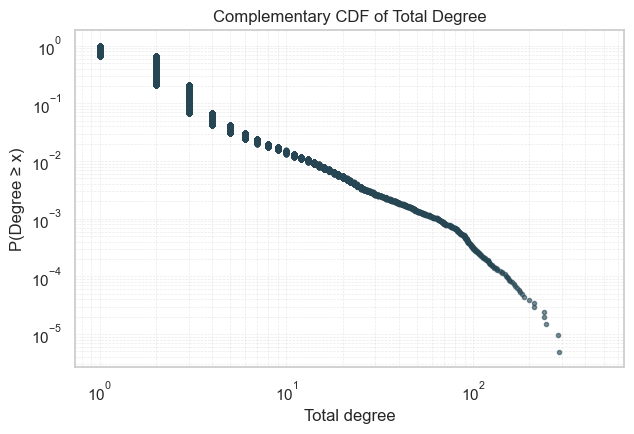

In [11]:
deg_pos = np.sort(deg['total_degree'].values)
deg_pos = deg_pos[deg_pos > 0]
ccdf = 1.0 - np.arange(1, len(deg_pos) + 1) / len(deg_pos)

fig, ax = plt.subplots(figsize=(6.5, 4.5))
ax.loglog(deg_pos, ccdf, marker='.', linestyle='none', alpha=0.6, color=COLOR_BASE)
ax.set_title('Complementary CDF of Total Degree')
ax.set_xlabel('Total degree')
ax.set_ylabel('P(Degree ≥ x)')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tight_layout()
plt.show()


### 5.6 Illicit share over time (labeled only)


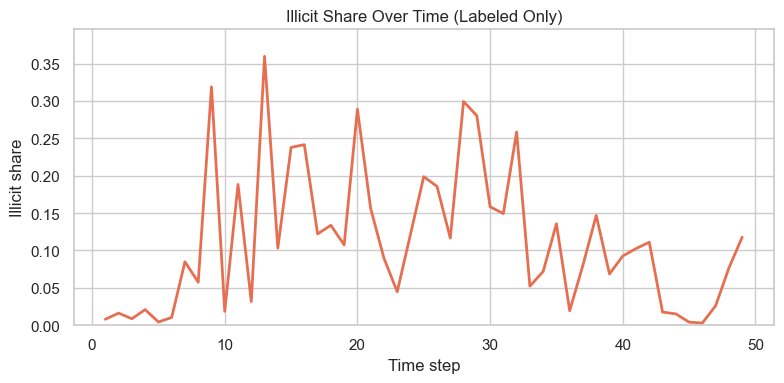

In [12]:
ts_counts = labeled.groupby(['time_step', 'class_label']).size().unstack(fill_value=0)
ts_counts = ts_counts.reindex(range(1, 50), fill_value=0)
illicit_share = ts_counts['illicit'] / (ts_counts['licit'] + ts_counts['illicit']).replace(0, np.nan)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(illicit_share.index, illicit_share.values, color=COLOR_ILLICIT, linewidth=2)
ax.set_title('Illicit Share Over Time (Labeled Only)')
ax.set_xlabel('Time step')
ax.set_ylabel('Illicit share')
ax.set_ylim(0, max(0.01, np.nanmax(illicit_share) * 1.1))
plt.tight_layout()
plt.show()


## Summary
- **Graph semantics:** Nodes are transactions, and directed edges represent money flowing between transactions.
- **Missing labels:** 157,205 of 203,769 transactions are `unknown` because only a subset are investigated/attributed.
- **Class imbalance:** Labeled data has 42,019 licit vs. 4,545 illicit transactions (illicit = 9.76%). This justifies weighted losses or resampling.
- **Temporal spikes:** Illicit activity peaks at time steps 32 (342 tx), 29 (329 tx), and 13 (291 tx), showing non-stationarity and motivating temporal splits.
- **Illicit share over time:** Even within labeled data, the illicit share fluctuates across time steps rather than staying constant.
- **Degree patterns:** Degree distribution is heavy-tailed; licit nodes have higher average degree (mean total degree 3.10) than illicit nodes (2.01).
- **Graph structure:** The graph is dominated by a large weakly connected component, with many smaller peripheral components.
- **Label mixing:** Edge label mixing reveals how often transactions connect within vs. across classes (homophily signal).
- **Edge composition:** Outgoing edges from each class mostly target `unknown`, reflecting label sparsity.
- **Feature correlations:** Several early features are highly correlated (e.g., |corr| ≈ 0.99), suggesting localized feature redundancy.
